![image.png](<https://i.typlog.com/tanxy/8334441283_179067.png>)
![image.png](<https://i.typlog.com/tanxy/8334441136_848434.png>)
![image.png](<https://i.typlog.com/tanxy/8334441068_628132.png>)

## 总结
+ NiN 块使用卷积层加两个 1×1 卷积层，
    + 后者对每个像素增加了非线性
+ NiN 使用全局平均池化层来替代 VGG 和 AlexNet 中的全连接层
    + 不容易过拟合，更少的参数个数

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

# 实现 NiN 块
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
        # 后面两个卷积可以看做参数受限的全连接层
    )

In [9]:
# NiN 模型
net = nn.Sequential(
    nin_blcok(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_blcok(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1), # 这里还是使用 Fashion-MNIST 数据集，所以输出还是 10
    nn.AdaptiveAvgPool2d((1, 1)), #全局平均池化层（自适应池化）
    nn.Flatten()
)

In [10]:
# 查看每块的输出形状
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


training on cuda:0


RuntimeError: CUDA out of memory. Tried to allocate 138.00 MiB (GPU 0; 4.00 GiB total capacity; 715.54 MiB already allocated; 0 bytes free; 738.00 MiB reserved in total by PyTorch)

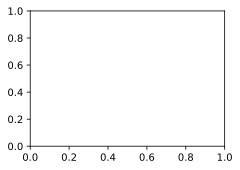

In [11]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())